In [4]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from numpy import ma
import os

def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))
           

def load_1d_data(fname,d, thresh, plot = True, vac_norm = 1):
    fp1 = [d + f for f in os.listdir(d) if f.endswith(fname +'.h5')]
    files1 = fp1[:]

    #     d2 = "C:/Users/qcrew/Desktop/qcrew/data/squeezing/20221110/"
    #     fp2 = [d2 + f for f in os.listdir(d2) if f.endswith(fname +'.h5')]
    #     fps = np.concatenate([fp1, fp2[:-1]])
    #     decay_times = np.array([1e3, 10e3, 20e3, 35e3, 50e3, 70e3, 100e3, 150e3, 200e3])
    # decay_times = np.array([1000.0, 10e3, 20e3, 35e3, 50e3, 70e3, 100e3, 150e3, 200e3])
        
    dg = []
    de = []
    dts = []

    vac_contrast =1 ## update with real experimental values
    for kk in range(len(files1)):
        fname = files1[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        data_q = data['Q'][:]
        dt = df.attrs['decay_time']
        x = data["x"][:, 0]
        #y = data["y"][0, :, 0]

        thresh = thresh #0.00018097066551268291
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]

        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        double_ps_g = ma.masked_array(m2_g, mask=m1).mean(axis=0) *1/vac_norm* 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1)).mean(axis=0) * 1/vac_norm*2 - 1

        dg.append(double_ps_g/vac_contrast)
        de.append(double_ps_e/vac_contrast)
        dts.append(dt)
        

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    dd = {}
    for n in range(len(decay_times)):
        dd[str(decay_times[n])] = []

    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
        
    d_avg = {}
    d_centre = {}

    for n, dt in enumerate(dts): 
        d_avg[str(dt)] = np.array(dd[str(dt)]).mean(axis=0)
        d_centre[str(dt)] = np.array(dd[str(dt)]).mean(axis=0).flatten().max()

    import math

    rows = len(decay_times)
    cols = 1
    if plot:
        fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
        # for i in range(rows):
        for j in range(rows):
            axes[j].plot(x, d_avg[str(decay_times[j])][:])
            axes[j].set_aspect("equal")
            axes[j].set_title(str(decay_times[j]))
        #         l += 1      
        plt.show()
    
    return d_avg, x, decay_times


## 0 dB

[ 3.61476059e+02 -7.81987727e-02]
0.00021633181712747438


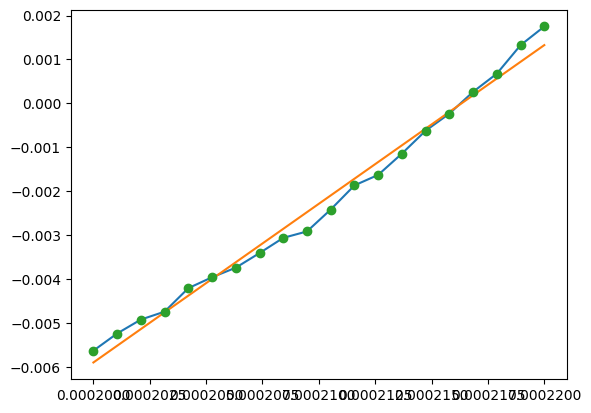

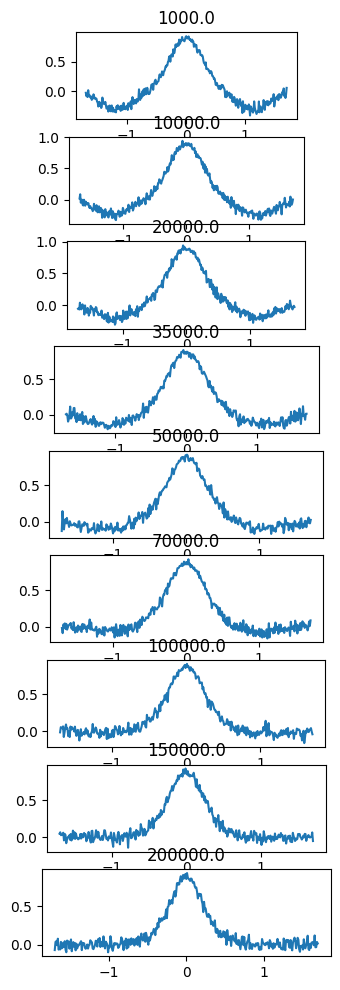

In [5]:
from scipy.optimize import curve_fit
fname = 'normal_cat_decay_loop_1d'
d =  "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"

thresholds = np.linspace(2e-4,2.2e-4, 20)
floor_values = []
for threshold in thresholds:
    data_array,x,  decay_times = load_1d_data(fname, d ,thresh=threshold, plot=False,vac_norm=1)
    floor_values.append(np.concatenate((data_array[str(decay_times[8])][:50],  data_array[str(decay_times[8])][-50:])).mean())
    
plt.plot(thresholds,floor_values)
from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)
d_avg, x, decay_times = load_1d_data(fname, d, thresh, vac_norm=1)

In [6]:
for i in range(len(decay_times)):
    print(np.max(d_avg[str(decay_times[i])]))

0.928178273723405
0.9392455759740251
0.939643182480349
0.9155008618534453
0.9170095580242166
0.9231941383091111
0.9083798706317451
0.9239298434821084
0.927485849554604


fit number 0, averaged peak position is -3.4755926205990324
fit number 1, averaged peak position is -3.46924730186334
fit number 2, averaged peak position is -3.391797105309108
fit number 3, averaged peak position is -3.297513413818107
fit number 4, averaged peak position is -3.2923260338934233
fit number 5, averaged peak position is -3.0582211495441003
fit number 6, averaged peak position is -3.712510550612712
fit number 7, averaged peak position is -3.037932624323763
fit number 8, averaged peak position is -3.9680245088106862


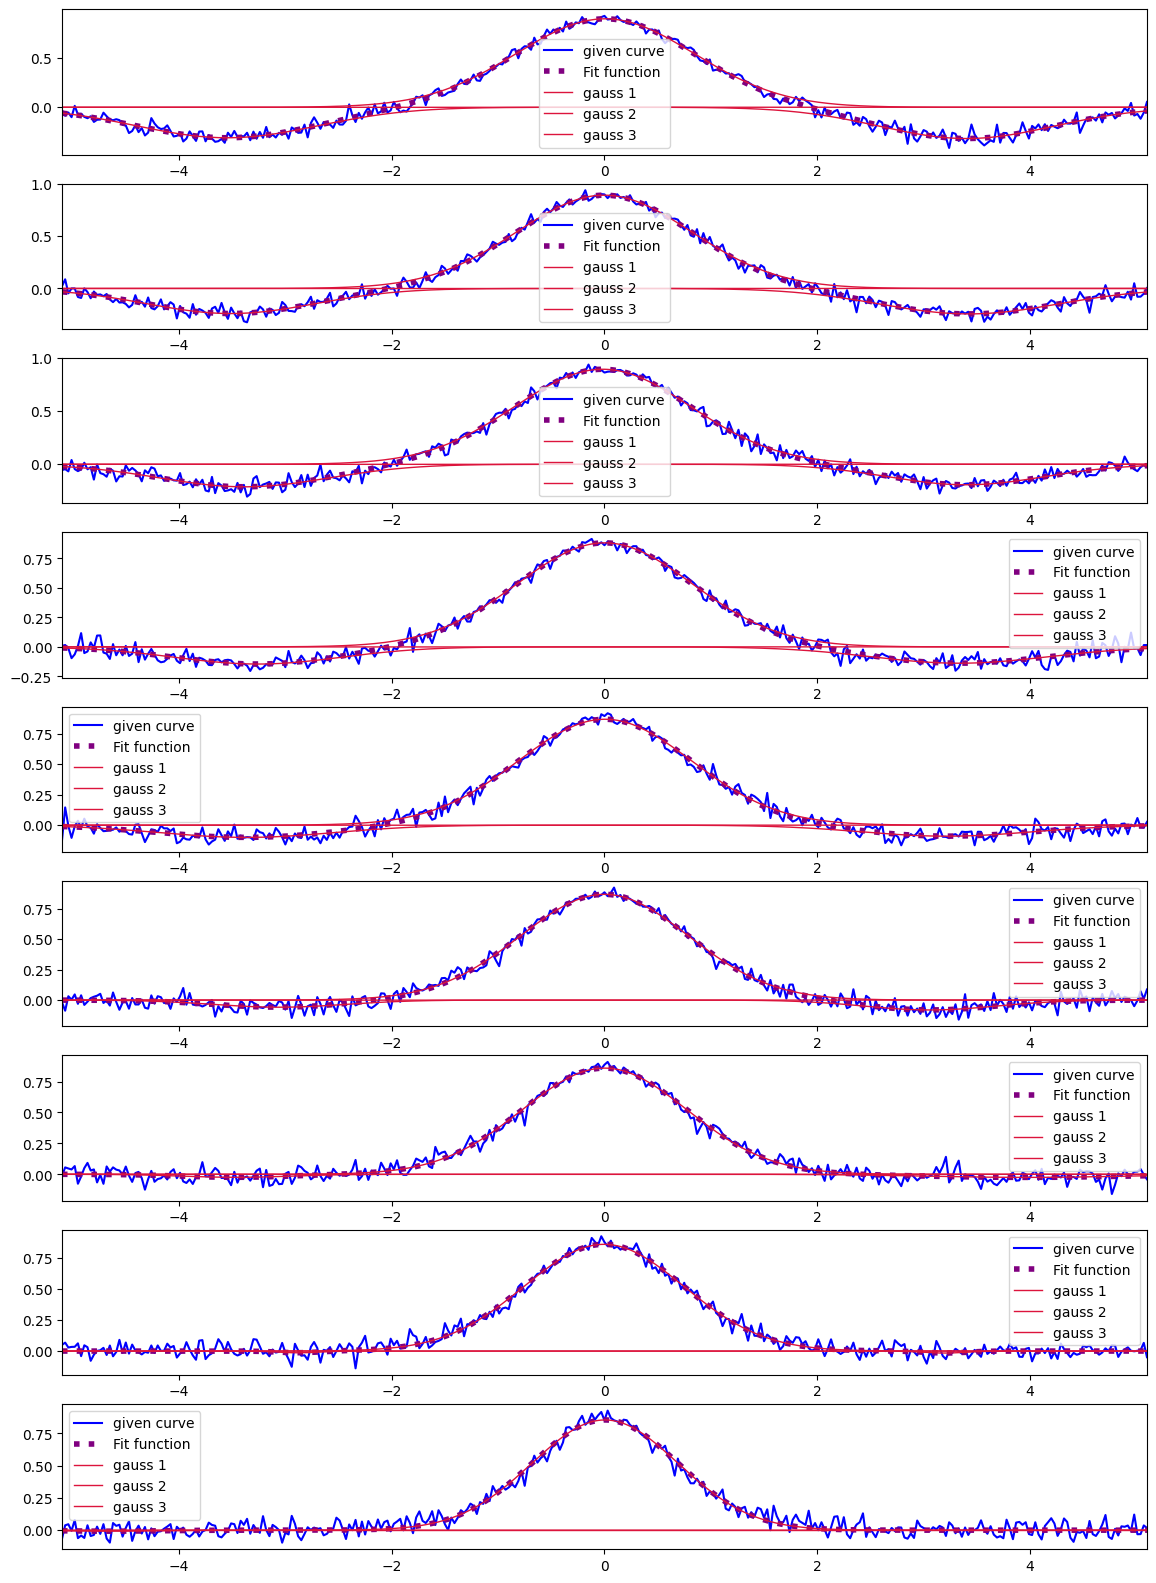

In [9]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt

rows = len(decay_times)
cols = 1
xvec = x*3
fig, axs = plt.subplots(rows, cols, figsize=(14, 20))

fit_amp_0db = []
fit_amp_std_cat = []
for i in range(rows):
    amp1 = -0.4
    sigma1 = 0.8
    cen1 = -3.5
    amp2 = 0.
    sigma2 = 1
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.9
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds =([-1, -5, 0.2 ,0, -0.5, 0 ,-1, 0, 0.2], 
             [0,2.5, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])
       
    
    y0 = gauss_3(xvec, *initial_guess)

    popt, pcov = curve_fit(gauss_3, xvec, d_avg[str(decay_times[i])], p0=initial_guess, bounds=bounds)
    print(f"fit number {i}, averaged peak position is {(popt[1]-popt[7])/2}" )
    fit_amp_0db.append((popt[0]+popt[6])/2)
    fit_amp_std_cat.append(np.sqrt(pcov[0][0]+pcov[6][6])/2) # take square root of averaged variances to find the std 
    
    axs[i].plot(xvec, d_avg[str(decay_times[i])], 'b', label="given curve")
    axs[i].plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


[-0.31385285 -0.2417117  -0.20284483 -0.14209552 -0.0952991  -0.06980456
 -0.02470569 -0.01496935 -0.00400144]


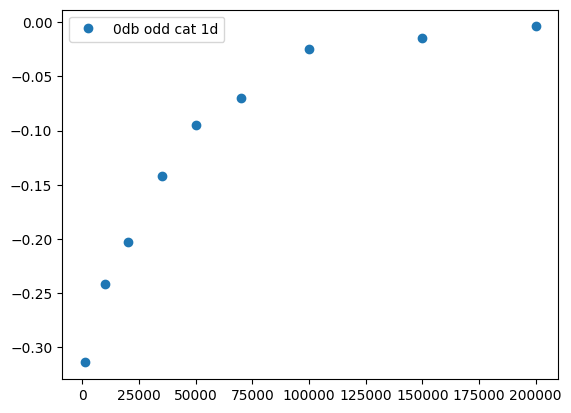

In [5]:

plt.plot(decay_times[:],np.array(fit_amp_0db[:]), "o", label = "0db odd cat 1d" )
plt.legend()
print(np.array(fit_amp_0db))

## 3dB


[ 3.23507943e+02 -5.33223996e-02]
0.00016482562703811767


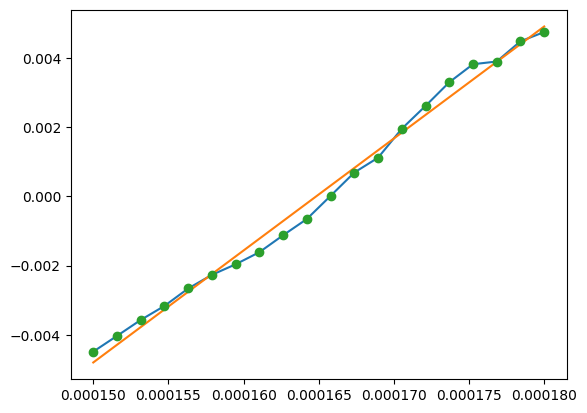

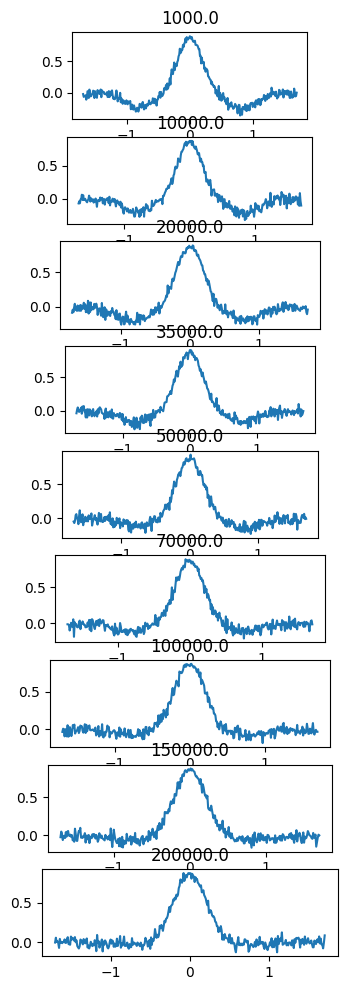

In [10]:
fname = 'panther_sq_vcat_3db_oddcat_1d'
d =  "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"


thresholds = np.linspace(1.5e-4,1.8e-4, 20)
floor_values = []
for threshold in thresholds:
    data_array,x,  decay_times = load_1d_data(fname, d ,thresh=threshold, plot=False)
    floor_values.append(np.concatenate((data_array[str(decay_times[8])][:50],  data_array[str(decay_times[8])][-50:])).mean())
    
plt.plot(thresholds,floor_values)
from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)
d_avg, x, decay_times = load_1d_data(fname, d, thresh)

In [11]:
np.concatenate((data_array[str(decay_times[8])][:70],  data_array[str(decay_times[8])][-70:])).mean()

0.00153011982353014

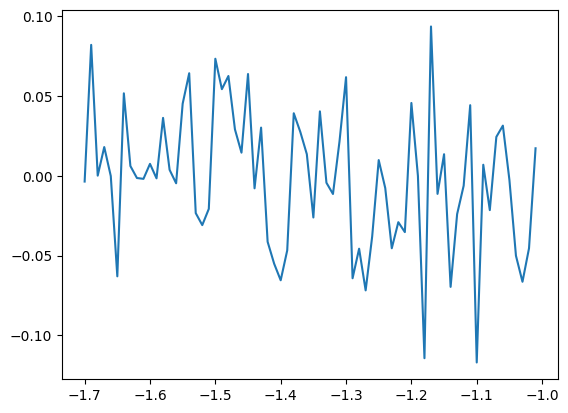

In [18]:
plt.plot(x[:70], data_array[str(decay_times[8])][:70])

fit number 0, averaged peak position is -2.4416945074745056
fit number 1, averaged peak position is -2.477283040584303
fit number 2, averaged peak position is -2.414197295012956
fit number 3, averaged peak position is -2.4032679730770394
fit number 4, averaged peak position is -2.3201613667383176
fit number 5, averaged peak position is -2.3961939595040276
fit number 6, averaged peak position is -2.2332377206392593
fit number 7, averaged peak position is -2.391179403346036
fit number 8, averaged peak position is -1.8009410662062777


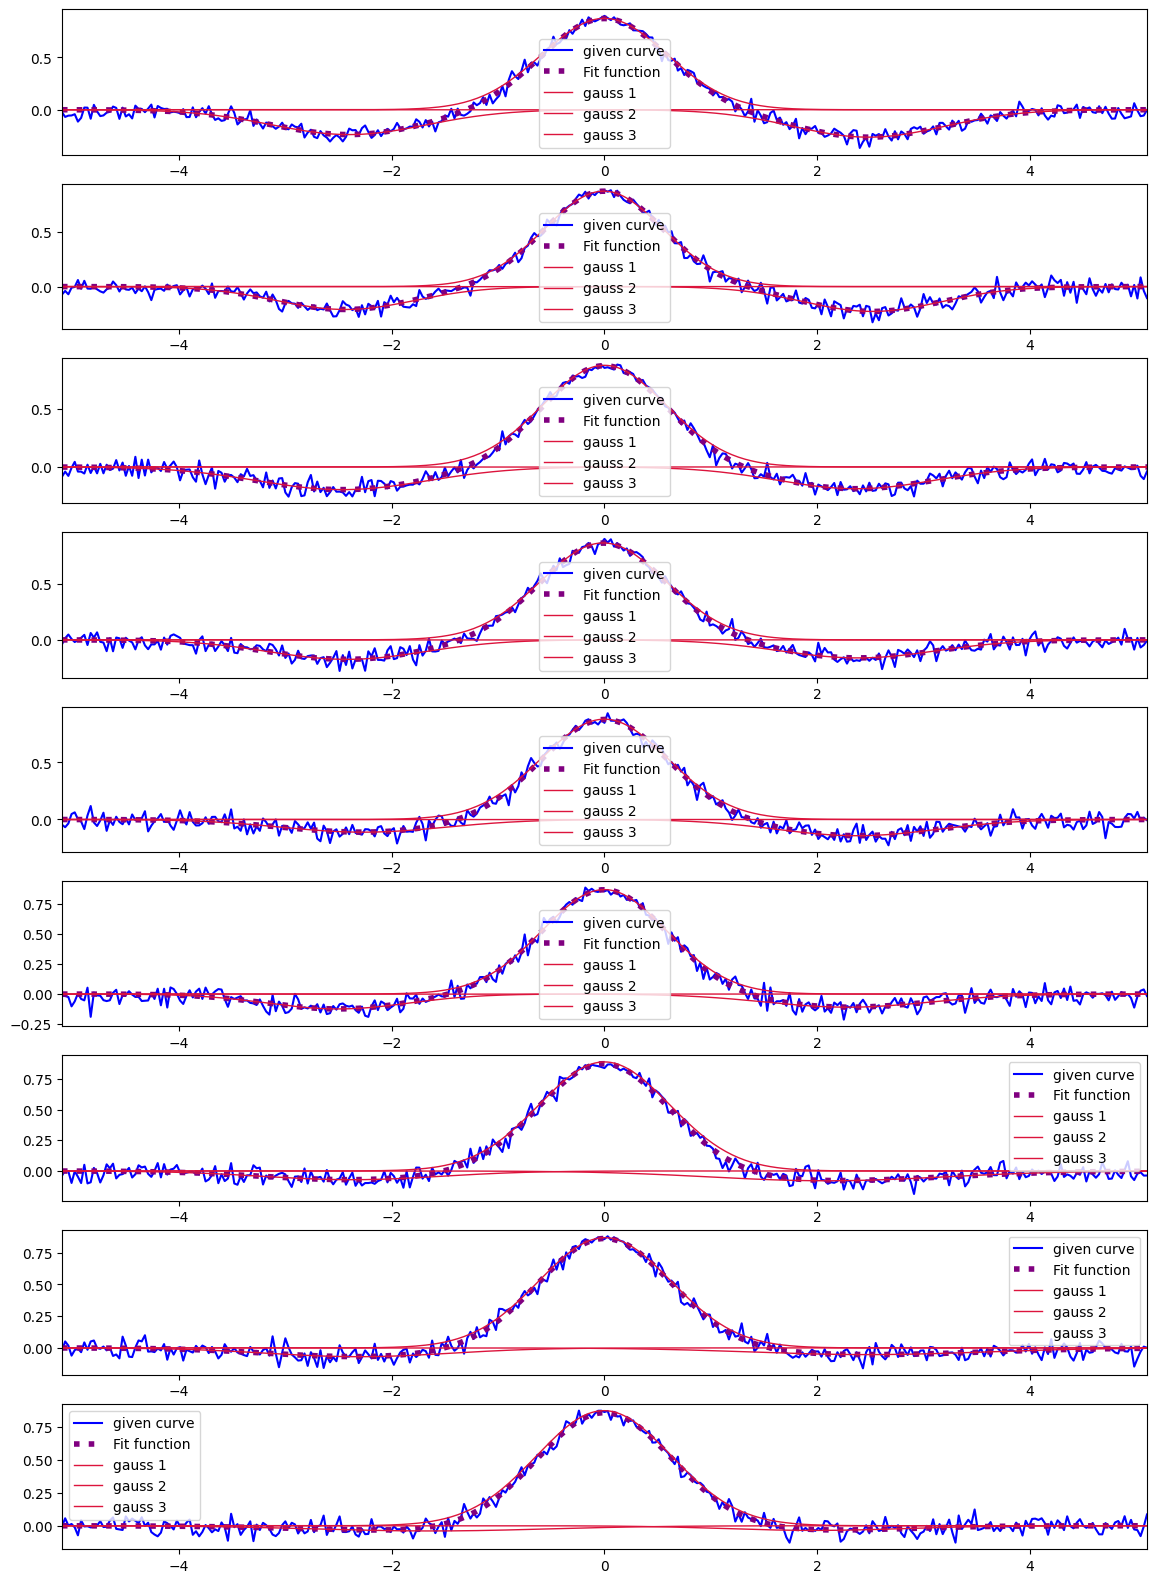

In [11]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt


xvec = x*3
fig, axs = plt.subplots(rows, cols, figsize=(14, 20))

fit_amp_3db = []
fit_amp_std_cat = []
for i in range(rows):
    amp1 = -0.4
    sigma1 = 0.8
    cen1 = -3.5
    amp2 = 0.
    sigma2 = 1
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.9
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds =([-1, -5, 0 ,0, -0.5, 0 ,-1, 0, 0], 
             [0, 0, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])
       
    
    y0 = gauss_3(xvec, *initial_guess)

    popt, pcov = curve_fit(gauss_3, xvec, d_avg[str(decay_times[i])], p0=initial_guess, bounds=bounds)
    print(f"fit number {i}, averaged peak position is {(popt[1]-popt[7])/2}" )
    fit_amp_3db.append((popt[0]+popt[6])/2)
    fit_amp_std_cat.append(np.sqrt(pcov[0][0]+pcov[6][6])/2) # take square root of averaged variances to find the std 
    
    axs[i].plot(xvec, d_avg[str(decay_times[i])], 'b', label="given curve")
    axs[i].plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


In [21]:
np.min(d_avg[str(decay_times[0])])

-0.36528187561180736

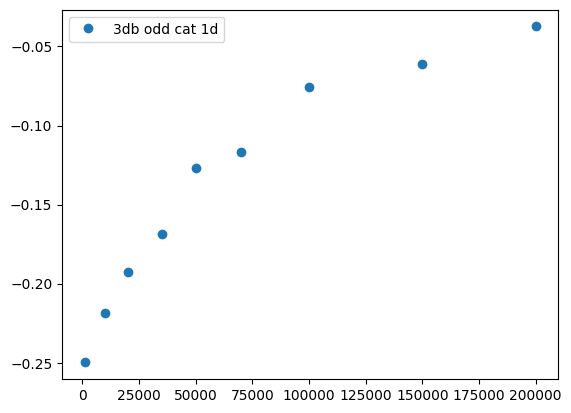

In [28]:

plt.plot(decay_times[:],np.array(fit_amp_3db[:]), "o", label = "3db odd cat 1d" )
plt.legend()

In [29]:
fit_amp_3db

[-0.24986625161238932,
 -0.21877324773798212,
 -0.19253162000591406,
 -0.1687664446777422,
 -0.12678755861350002,
 -0.11678634019492565,
 -0.07546512576939299,
 -0.06101610086945519,
 -0.037362430954080386]

## 6dB

[ 3.13459002e+02 -6.48383981e-02]
0.00020684809696071223


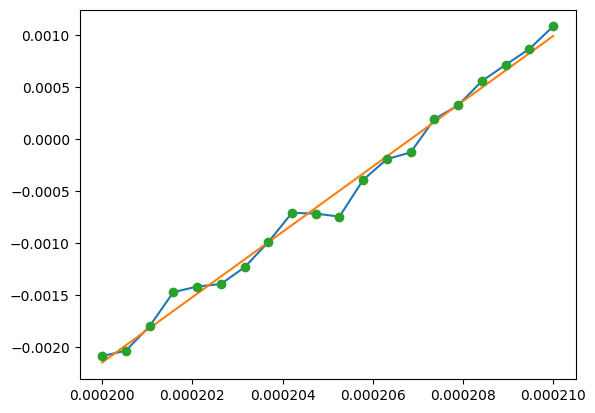

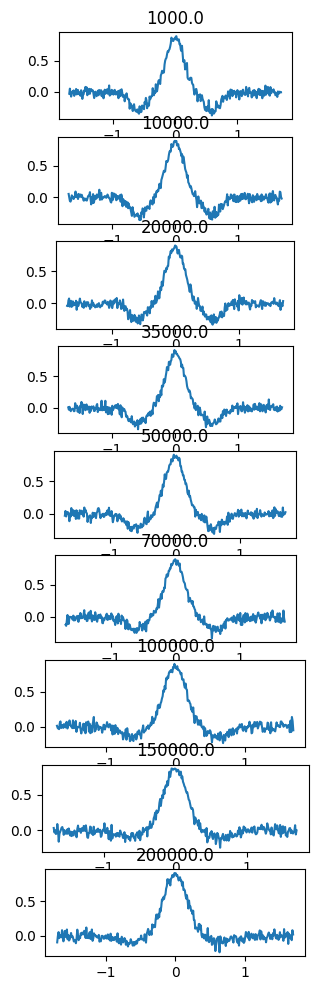

In [12]:
from scipy.optimize import curve_fit

fname = 'panther_sq_vcat_6db_oddcat_1d'
d =  "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"

thresholds = np.linspace(2e-4,2.1e-4, 20)
floor_values = []
for threshold in thresholds:
    data_array,x,  decay_times = load_1d_data(fname, d ,thresh=threshold, plot=False)
    floor_values.append(np.concatenate((data_array[str(decay_times[8])][:50],  data_array[str(decay_times[8])][-50:])).mean())
    
plt.plot(thresholds,floor_values)
from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)
d_avg, x, decay_times = load_1d_data(fname, d, thresh)

In [23]:
np.min(d_avg[str(decay_times[0])])

-0.381578904273036

fit number 0, averaged peak position is -1.7673888706164678
fit number 1, averaged peak position is -1.753785461764538
fit number 2, averaged peak position is -1.784821819586939
fit number 3, averaged peak position is -1.7864023379097083
fit number 4, averaged peak position is -1.8234966213682782
fit number 5, averaged peak position is -1.8426515320014232
fit number 6, averaged peak position is -1.8728558686636605
fit number 7, averaged peak position is -1.9062100328017961
fit number 8, averaged peak position is -1.9191996113205048


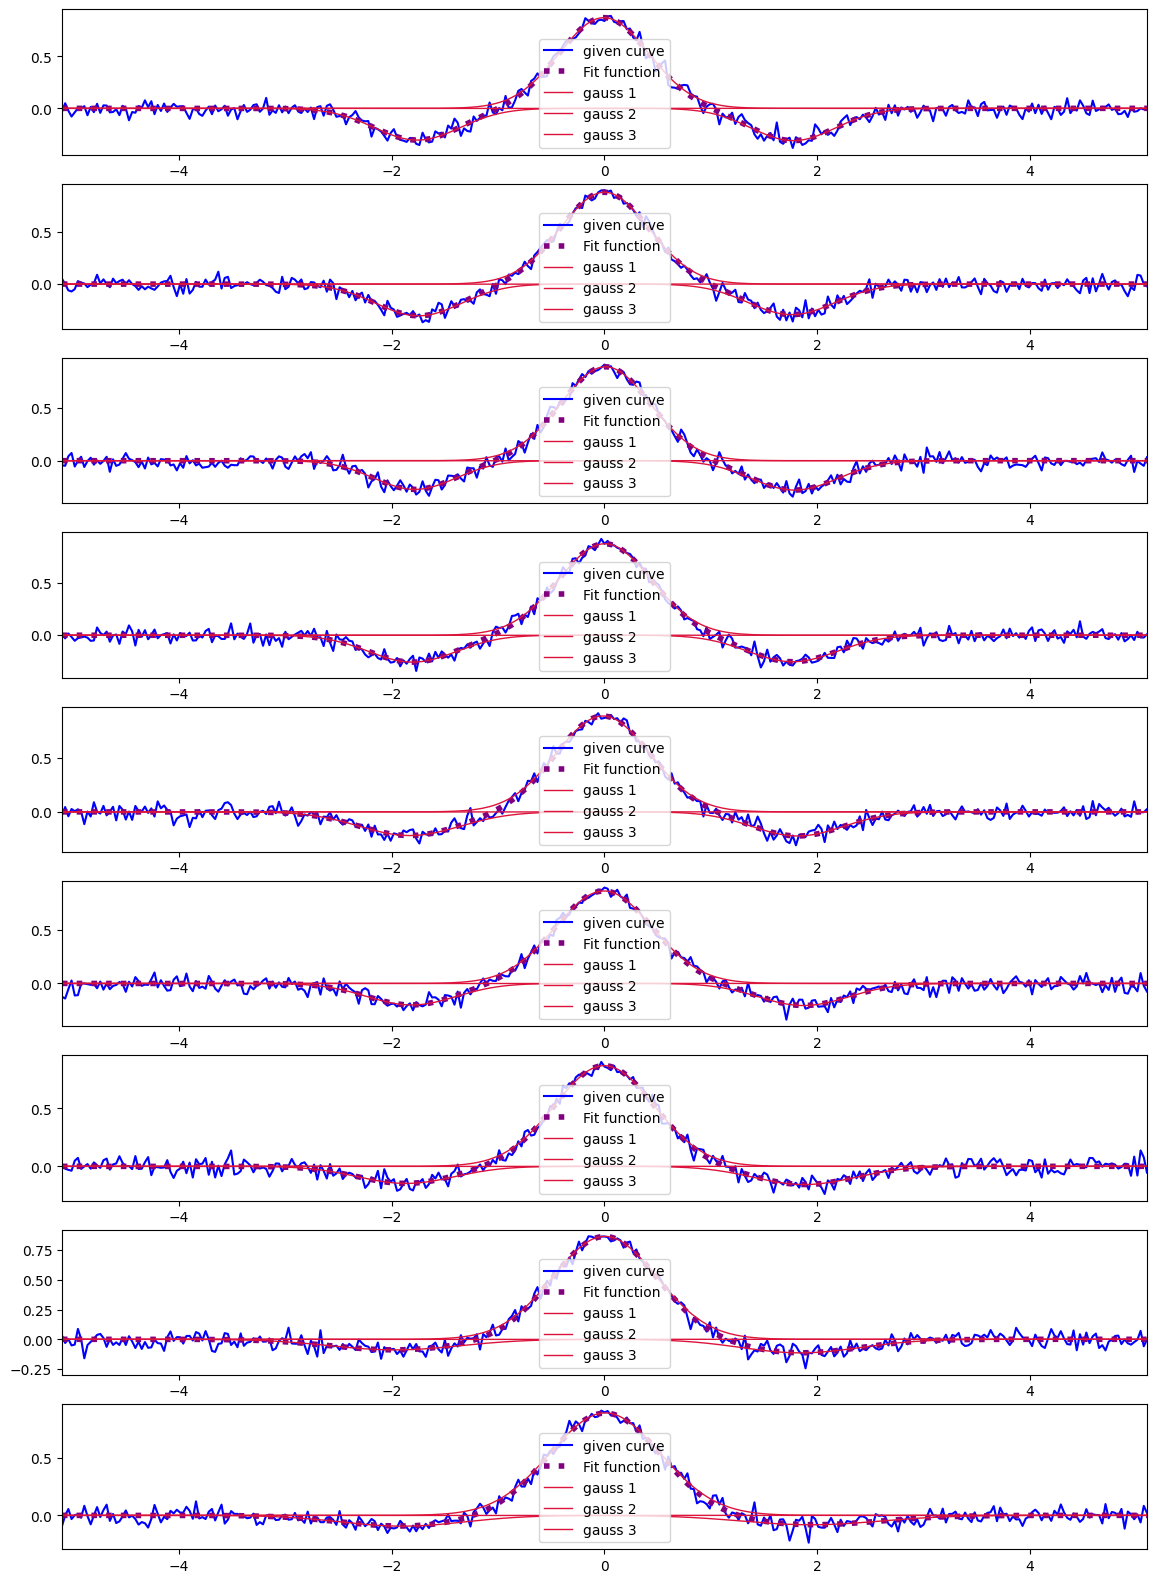

In [13]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt


xvec = x*3
fig, axs = plt.subplots(rows, cols, figsize=(14, 20))

fit_amp_6db = []
fit_amp_std_cat = []
for i in range(rows):
    amp1 = -0.4
    sigma1 = 0.8
    cen1 = -3.5
    amp2 = 0.
    sigma2 = 1
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.9
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds =([-1, -5, 0 ,0, -0.5, 0 ,-1, 0, 0], 
             [0, 0, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])
       
    
    y0 = gauss_3(xvec, *initial_guess)

    popt, pcov = curve_fit(gauss_3, xvec, d_avg[str(decay_times[i])], p0=initial_guess, bounds=bounds)
    print(f"fit number {i}, averaged peak position is {(popt[1]-popt[7])/2}" )
    fit_amp_6db.append((popt[0]+popt[6])/2)
    fit_amp_std_cat.append(np.sqrt(pcov[0][0]+pcov[6][6])/2) # take square root of averaged variances to find the std 
    
    axs[i].plot(xvec, d_avg[str(decay_times[i])], 'b', label="given curve")
    axs[i].plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


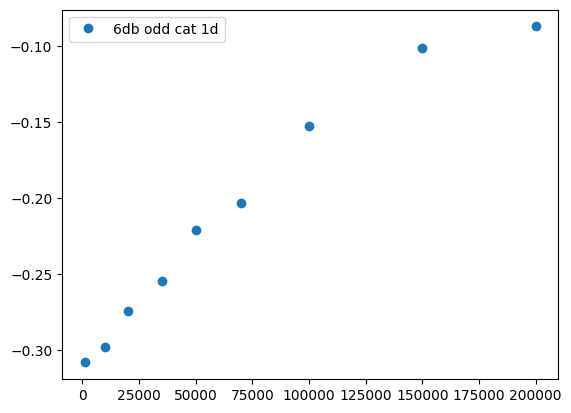

In [11]:

plt.plot(decay_times[:],np.array(fit_amp_6db[:]), "o", label = "6db odd cat 1d" )
plt.legend()

In [12]:
fit_amp_6db

[-0.3083789742009914,
 -0.2984478443568425,
 -0.27461330709822623,
 -0.2548668912808472,
 -0.22099120354677365,
 -0.20324927830265505,
 -0.15243910999419236,
 -0.10139761580299028,
 -0.08727175194823064]

### 7dB

[ 4.74922444e+02 -1.05104966e-01]
0.0002213097480691249


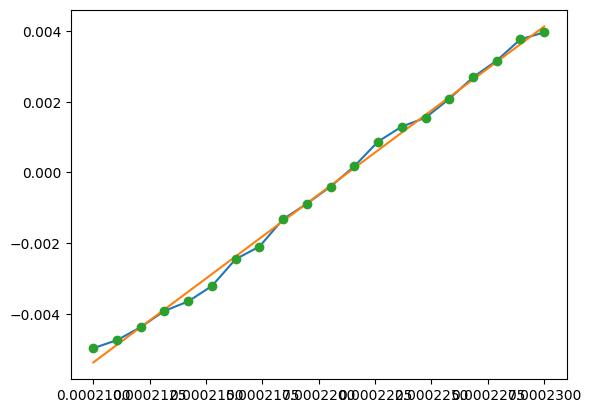

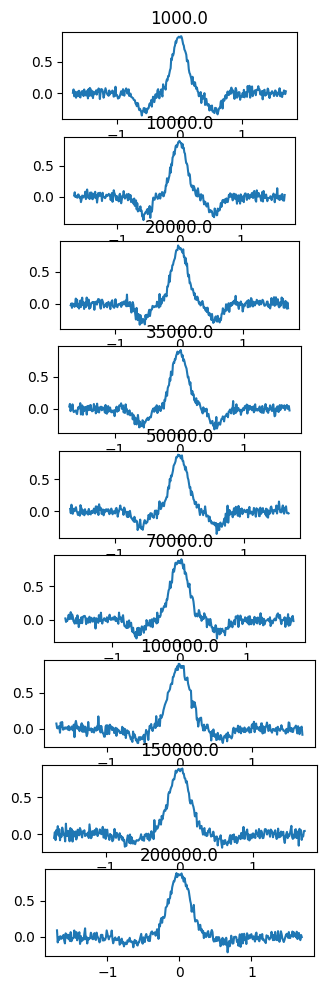

In [14]:

fname = 'panther_sq_vcat_7db_oddcat_1d'
d =  "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/"

thresholds = np.linspace(2.1e-4,2.3e-4, 20)
floor_values = []
for threshold in thresholds:
    data_array,x,  decay_times = load_1d_data(fname, d ,thresh=threshold, plot=False)
    floor_values.append(np.concatenate((data_array[str(decay_times[8])][:50],  data_array[str(decay_times[8])][-50:])).mean())
    
plt.plot(thresholds,floor_values)
from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)
d_avg, x, decay_times = load_1d_data(fname, d, thresh)
    

fit number 0, averaged peak position is -1.6958576830579013
fit number 1, averaged peak position is -1.6944658708507438
fit number 2, averaged peak position is -1.7179078587476462
fit number 3, averaged peak position is -1.7456930475630754
fit number 4, averaged peak position is -1.7886129418168788
fit number 5, averaged peak position is -1.856229053811421
fit number 6, averaged peak position is -1.7534159788751953
fit number 7, averaged peak position is -1.920784612103772
fit number 8, averaged peak position is -2.0357547839205496


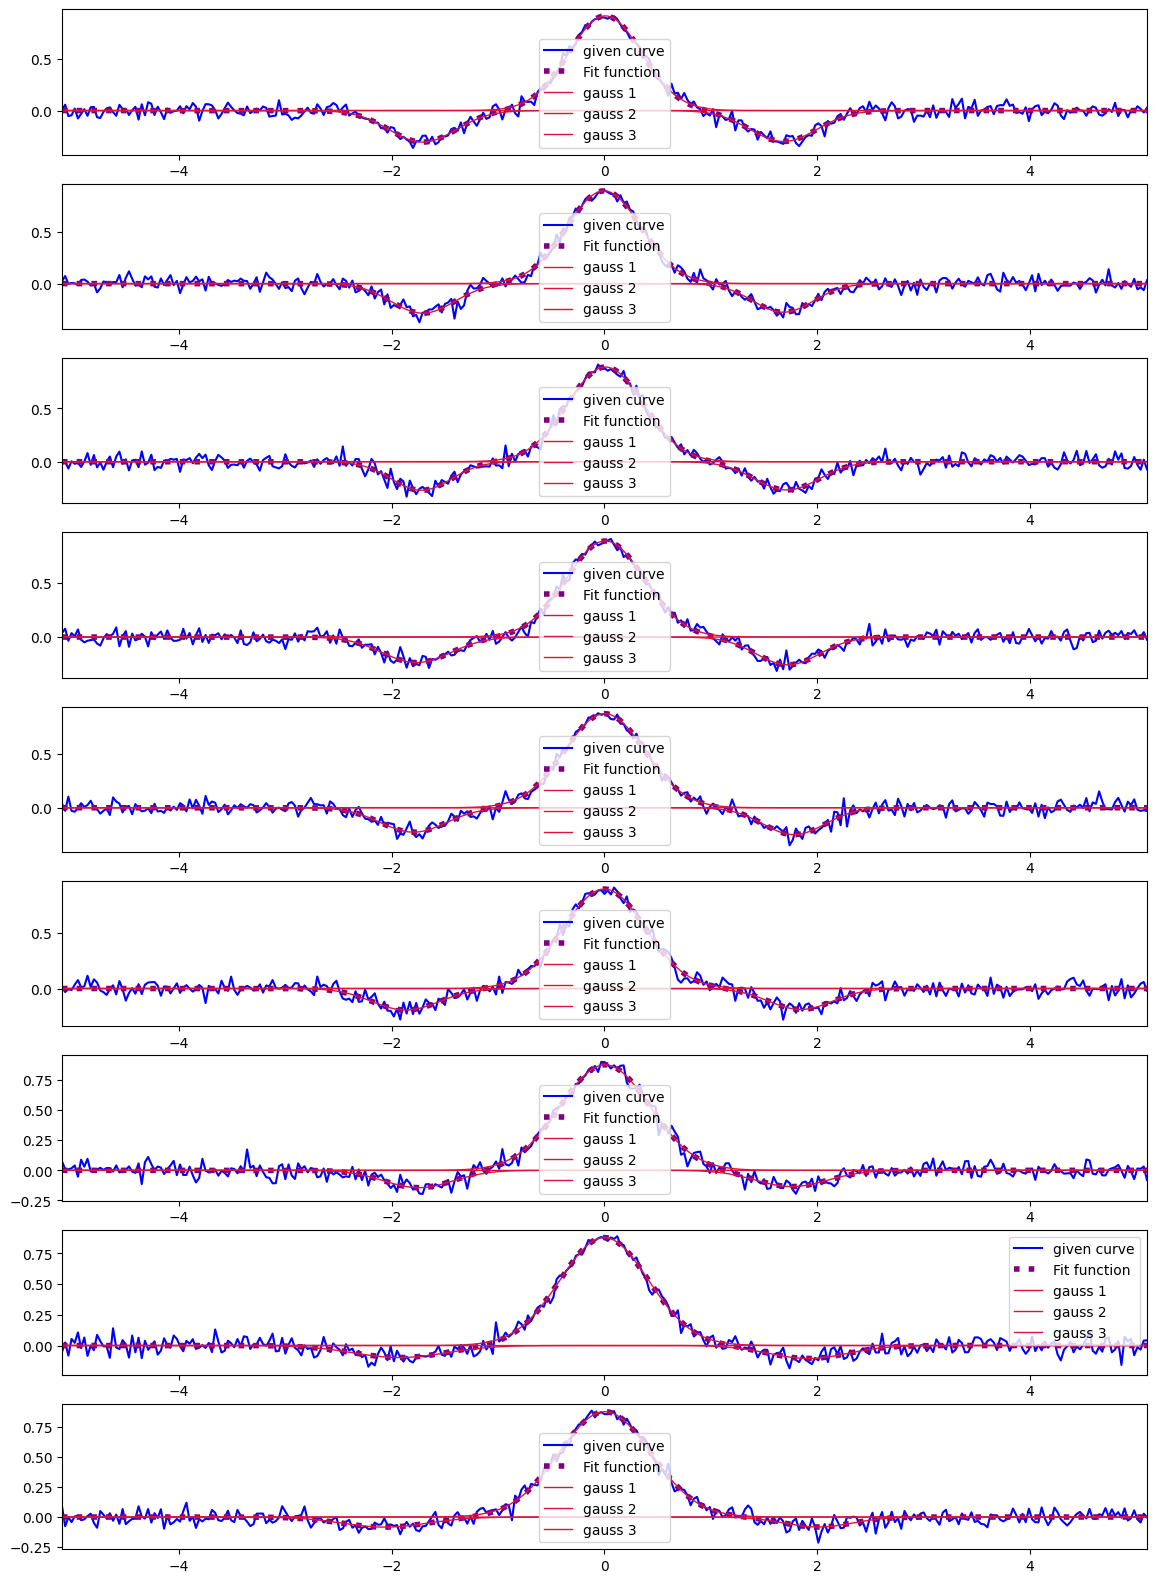

In [15]:
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt


xvec = x*3
fig, axs = plt.subplots(rows, cols, figsize=(14, 20))

fit_amp_7db = []
fit_amp_std_cat = []
for i in range(rows):
    amp1 = -0.4
    sigma1 = 0.8
    cen1 = -3.5
    amp2 = 0.
    sigma2 = 1
    cen2 = 0
    amp3 = -0.4
    sigma3 = 0.9
    cen3 = 3.5
    initial_guess = [amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3]
    bounds =([-1, -5, 0 ,0, -0.5, 0 ,-1, 0, 0], 
             [0, 0, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])
       
    
    y0 = gauss_3(xvec, *initial_guess)

    popt, pcov = curve_fit(gauss_3, xvec, d_avg[str(decay_times[i])], p0=initial_guess, bounds=bounds)
    print(f"fit number {i}, averaged peak position is {(popt[1]-popt[7])/2}" )
    fit_amp_7db.append((popt[0]+popt[6])/2)
    fit_amp_std_cat.append(np.sqrt(pcov[0][0]+pcov[6][6])/2) # take square root of averaged variances to find the std 
    
    axs[i].plot(xvec, d_avg[str(decay_times[i])], 'b', label="given curve")
    axs[i].plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
    for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
        axs[i].plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
    axs[i].legend()
    axs[i].autoscale(axis='x', tight=True)
plt.show()


Text(0, 0.5, 'blob height times -1')

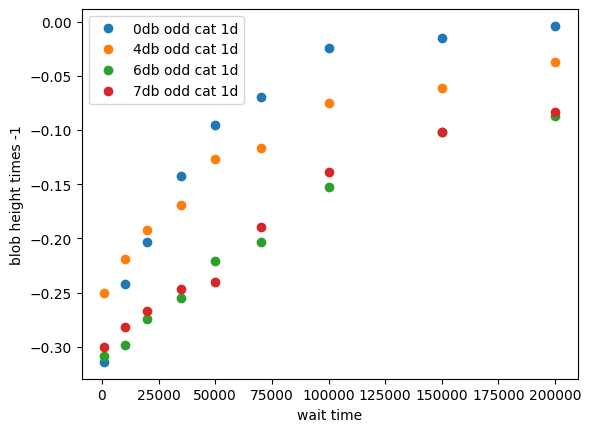

In [30]:


plt.plot(decay_times[:],np.array(fit_amp_0db), "o", label = "0db odd cat 1d")  
plt.plot(decay_times[:],np.array(fit_amp_3db[:]), "o", label = "3db odd cat 1d" )
plt.plot(decay_times[:],np.array(fit_amp_6db[:]), "o", label = "6db odd cat 1d" )
plt.plot(decay_times[:],np.array(fit_amp_7db[:]), "o", label = "7db odd cat 1d" )
plt.legend()
plt.xlabel("wait time")
plt.ylabel("blob height times -1") 

Text(0, 0.5, 'blob height times -1')

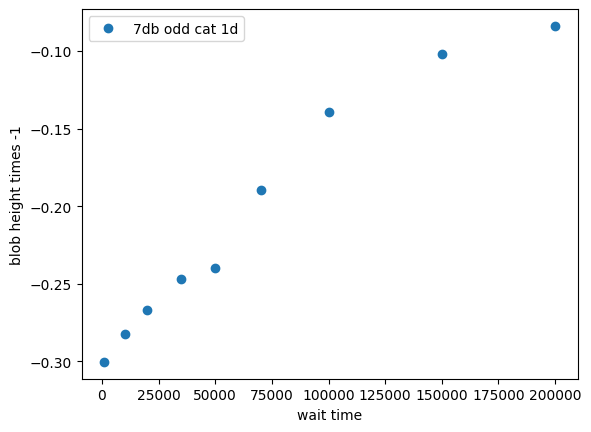

In [18]:


# plt.plot(decay_times[:],np.array(odd_cat)*-1, "o", label = "odd cat 2d")  
# plt.plot(decay_times[:],np.array(fit_amp_6db[:])*-1, "o", label = "6db odd cat 1d" )
plt.plot(decay_times[:],np.array(fit_amp_7db[:]), "o", label = "7db odd cat 1d" )
plt.legend()
plt.xlabel("wait time")
plt.ylabel("blob height times -1") 

In [20]:
fit_amp_7db

[-0.30029527407914025,
 -0.28209631046738926,
 -0.26662039277592886,
 -0.24676311818479252,
 -0.23974256715254594,
 -0.18967807571026812,
 -0.13913717491480074,
 -0.10171853420753853,
 -0.08382027790868449]